In [1]:
library(cowplot)
library(ggrepel)
library(tidyverse)

theme_set(theme_cowplot())
results <- '../results/'

method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff7f00', 'SConES GS' = '#fb6a4a',
                    'SConES GM' = '#cb181d', 'SConES GI' = '#67000d',
                    'SigMod' = '#377eb8', 'All' = 'black')


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# HT network

## Prediction accuracy

In [2]:
pred_ht <- read_tsv(paste0(results,'benchmark/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'all_snps', 'All', method))

In [3]:
summary(pred_ht$sensitivity)
summary(pred_ht$specificity)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4893  0.5149  0.5354  0.5356  0.5487  0.5991 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4855  0.5076  0.5368  0.5365  0.5593  0.6106 

method,se_sensitivity,se_specificity,sensitivity,specificity
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
All,0.012548685,0.017712061,0.5503509,0.5528553
dmGWAS,0.010307572,0.012278595,0.5292769,0.5275422
heinz,0.013390071,0.020205997,0.5565479,0.5562663
hotnet2,0.013448257,0.009172769,0.5403945,0.5392719
SConES GI,0.012997862,0.008783806,0.5222288,0.5216051
SConES GM,0.010864636,0.017907548,0.5249940,0.5314832
SConES GS,0.009123022,0.017278588,0.5371971,0.5411949
SigMod,0.006872304,0.014768539,0.5235145,0.5220717


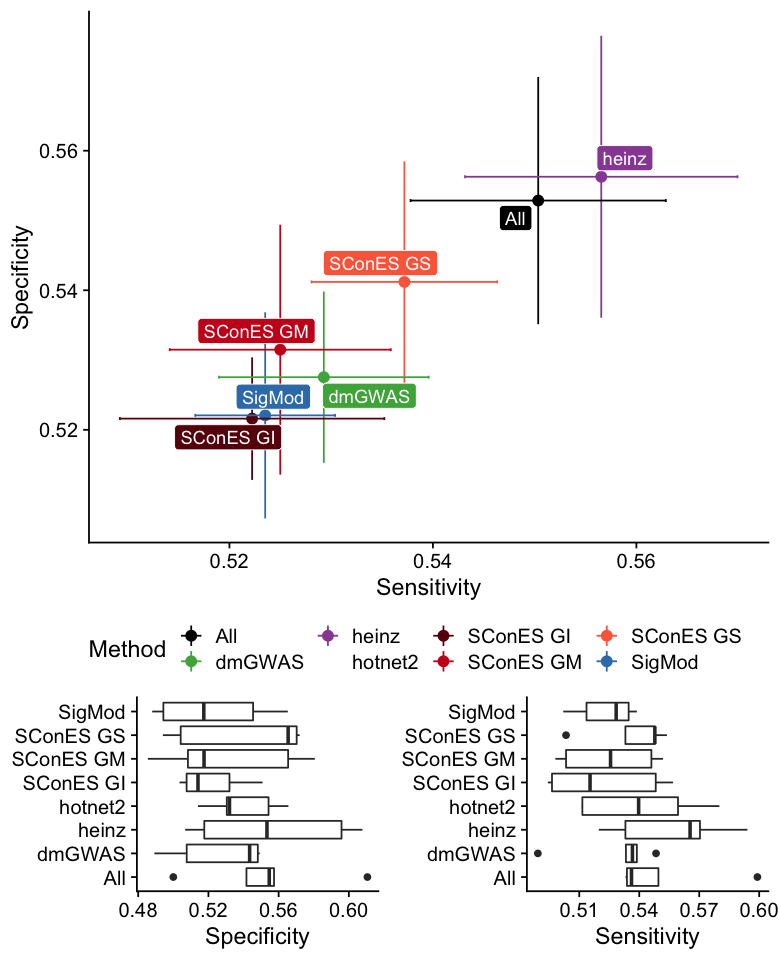

In [4]:
options(repr.plot.width=6.5, repr.plot.height=8)
specificity <- ggplot(pred_ht, aes(x = method, y = specificity)) +
    geom_boxplot() +
    coord_flip() +
    labs(y = 'Specificity') +
    theme(axis.title.y = element_blank())

sensitivity <- ggplot(pred_ht, aes(x = method, y = sensitivity)) +
    geom_boxplot() +
    coord_flip() +
    labs(y = 'Sensitivity') +
    theme(axis.title.y = element_blank())

sens_spec_df <- pred_ht %>%
    group_by(method) %>%
    summarize(se_sensitivity = sd(sensitivity) / sqrt(n()),
              se_specificity = sd(specificity) / sqrt(n()),
              sensitivity = mean(sensitivity),
              specificity = mean(specificity))
sens_spec_df

sens_spec <- ggplot(sens_spec_df, aes(x = sensitivity, y = specificity, 
           label = method, fill = method, color = method)) +
    geom_pointrange(aes(ymin = specificity - se_specificity, 
                        ymax = specificity + se_specificity)) +
    geom_errorbarh(aes(xmax = sensitivity + se_sensitivity, 
                       xmin = sensitivity - se_sensitivity)) +
    geom_label_repel(color = 'white') +
#         scale_y_continuous(limits = c(0.46, 0.62)) +
#         scale_x_continuous(limits = c(0.46, 0.62)) +
    scale_fill_manual(values = method_palette) +
    scale_color_manual(values = method_palette) +
    labs(x = 'Sensitivity', y = 'Specificity', color = 'Method') +
    theme(legend.position = 'bottom') + 
    guides(fill = "none")

plot_grid(sens_spec, plot_grid(specificity, sensitivity), nrow = 2, 
          rel_heights = c(2.5,1))

## Size of the solution

method,se_selected,se_active,n_selected,n_active_set,percentage
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dmGWAS,562.7479,28.878019,4255.0,319.8,7.515864
heinz,0.0000,1.933908,182.0,9.8,5.384615
hotnet2,409.3576,13.883083,7737.4,622.8,8.049215
SConES GI,1951.5789,188.355674,6256.6,765.6,12.236678
SConES GM,1966.0756,270.777399,3859.6,449.0,11.633330
SConES GS,371.3512,11.795762,1334.0,41.2,3.088456
SigMod,291.0294,20.462160,2616.8,298.0,11.387955


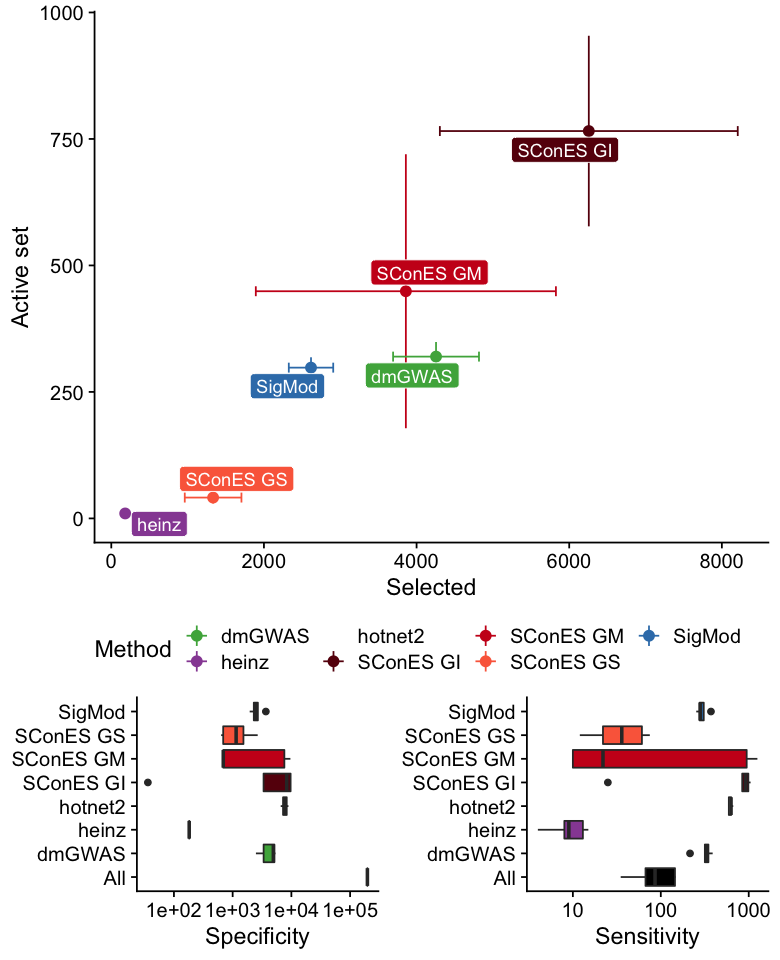

In [5]:
options(repr.plot.width=6.5, repr.plot.height=8)
selected <- ggplot(pred_ht, aes(x = method, y = n_selected, fill = method)) +
    geom_boxplot() +
    scale_y_log10() +
    coord_flip() +
    scale_fill_manual(values = method_palette) +
    labs(y = 'Specificity') +
    theme(axis.title.y = element_blank()) +
    theme(legend.position = 'none')

active <- ggplot(pred_ht, aes(x = method, y = n_active_set, fill = method)) +
    geom_boxplot() +
    scale_y_log10() +
    coord_flip() +
    scale_fill_manual(values = method_palette) +
    labs(y = 'Sensitivity') +
    theme(axis.title.y = element_blank()) +
    theme(legend.position = 'none')

sel_act_df <- pred_ht %>%
    filter(method != 'All') %>%
    group_by(method) %>%
    summarize(se_selected = sd(n_selected) / sqrt(n()),
              se_active = sd(n_active_set) / sqrt(n()),
              n_selected = mean(n_selected),
              n_active_set = mean(n_active_set),
              percentage = 100 * (n_active_set / n_selected))
sel_act_df

sel_act <- ggplot(sel_act_df, aes(x = n_selected, y = n_active_set, 
               label = method, fill = method, color = method)) +
        geom_pointrange(aes(ymin = n_active_set - se_active, 
                            ymax = n_active_set + se_active)) +
        geom_errorbarh(aes(xmax = n_selected + se_selected, 
                           xmin = n_selected - se_selected)) +
        geom_label_repel(color = 'white') +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Selected', y = 'Active set', color = 'Method') +
        theme(legend.position = 'bottom') + 
        guides(fill = "none")

plot_grid(sel_act, plot_grid(selected, active), nrow = 2, rel_heights = c(2.5,1))

## Stability

In [6]:
stab_ht <- read_tsv(paste0(results,'benchmark/stability.tsv'), col_types = 'cicd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method))

Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”


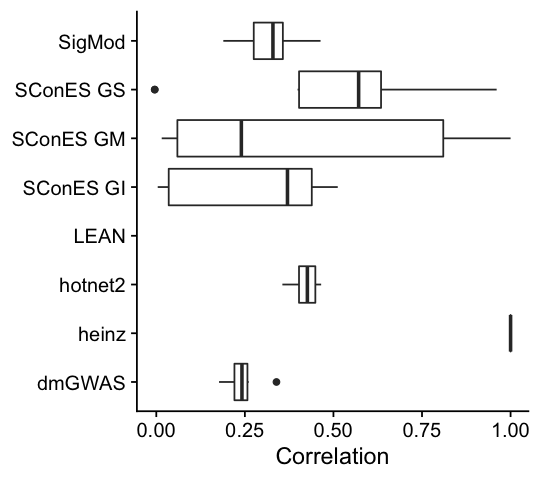

In [7]:
options(repr.plot.width=4.5, repr.plot.height=4)
ggplot(stab_ht, aes(x = method, y = pearson)) +
    geom_boxplot() +
    coord_flip() +
    labs(y = 'Correlation') +
    theme(axis.title.y = element_blank())

## Computational time

In [8]:
parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else if (grepl('d', x)) {
            x <- gsub('d', '', x) %>% as.numeric
            x <- x * 3600 * 24
        } else {
            x <- NA
        }
        return(x)   
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist  
}

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [64, 110].”


[1] 112820.2

method,time_s,time_star
<chr>,<dbl>,<dbl>
dmGWAS,35504.00,148324.2
heinz,16.16,112836.4
hotnet2,308402.20,421222.4
LEAN,344.60,113164.8
SConES GI,102252.60,102252.6
SConES GM,3125.20,3125.2
SConES GS,453.80,453.8
SigMod,621.40,113441.6


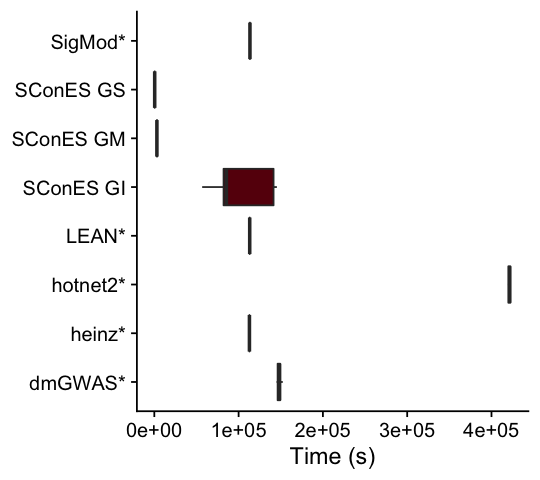

In [9]:
time <- read_tsv(paste0(results,'benchmark/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method)) %>%
    mutate(time_s = parse_deltatime(realtime))

vegas <- mean(time$time_s[time$method == 'vegas'])

options(repr.plot.width=4.5, repr.plot.height=4)
time_star <- time %>%
    filter(method != 'vegas') %>%
    mutate(time_star = ifelse(grepl('SConES', method), time_s, time_s + vegas),
           method_star = ifelse(grepl('SConES', method), method, paste0(method,'*')))

vegas
time_star %>%
    group_by(method) %>%
    summarize(time_s = mean(time_s),
              time_star = mean(time_star))

ggplot(time_star, aes(x = method_star, y = time_star, fill = method)) +
    geom_boxplot() +
    scale_fill_manual(values = method_palette) +
    labs(y = 'Time (s)') +
    theme(legend.position = 'none',
          axis.title.y = element_blank()) +
    coord_flip()

# HT+LC network

In [10]:
pred_lc <- read_tsv(paste0(results,'lc_ht_network/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method))

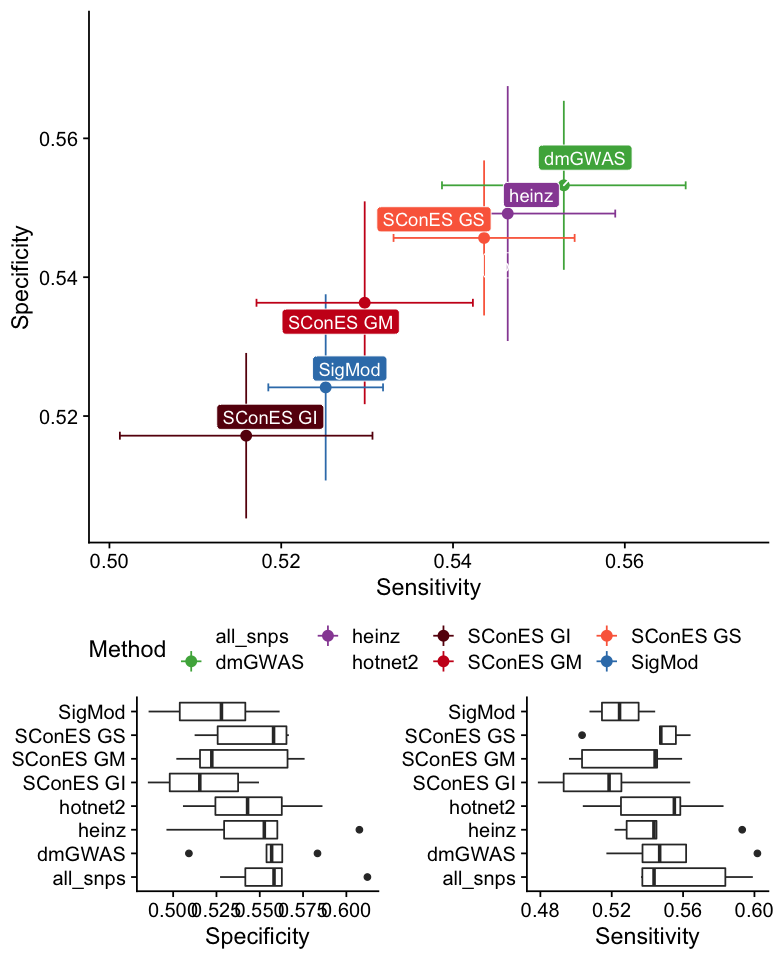

In [11]:
options(repr.plot.width=6.5, repr.plot.height=8)
specificity <- ggplot(pred_lc, aes(x = method, y = specificity)) +
    geom_boxplot() +
    coord_flip() +
    labs(y = 'Specificity') +
    theme(axis.title.y = element_blank())

sensitivity <- ggplot(pred_lc, aes(x = method, y = sensitivity)) +
    geom_boxplot() +
    coord_flip() +
    labs(y = 'Sensitivity') +
    theme(axis.title.y = element_blank())

sens_spec <- pred_lc %>%
    group_by(method) %>%
    summarize(se_sensitivity = sd(sensitivity) / sqrt(n()),
              se_specificity = sd(specificity) / sqrt(n()),
              sensitivity = mean(sensitivity),
              specificity = mean(specificity)) %>%
    ggplot(aes(x = sensitivity, y = specificity, 
               label = method, fill = method, color = method)) +
        geom_pointrange(aes(ymin = specificity - se_specificity, 
                            ymax = specificity + se_specificity)) +
        geom_errorbarh(aes(xmax = sensitivity + se_sensitivity, 
                           xmin = sensitivity - se_sensitivity)) +
        geom_label_repel(color = 'white') +
#         scale_y_continuous(limits = c(0.46, 0.62)) +
#         scale_x_continuous(limits = c(0.46, 0.62)) +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Sensitivity', y = 'Specificity', color = 'Method') +
        theme(legend.position = 'bottom') + 
        guides(fill = "none")

plot_grid(sens_spec, plot_grid(specificity, sensitivity), nrow = 2, 
          rel_heights = c(2.5,1))

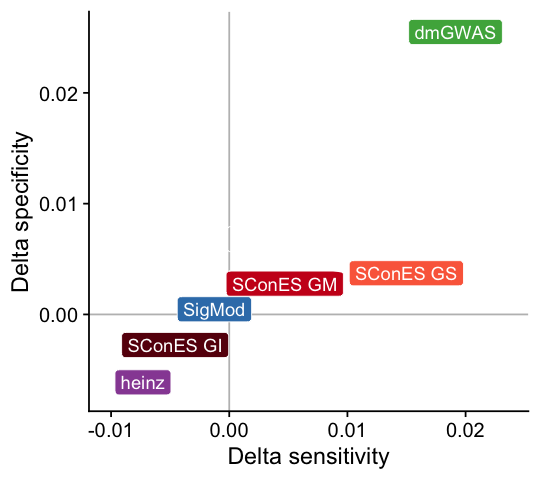

In [12]:
options(repr.plot.width=4.5, repr.plot.height=4)
inner_join(pred_lc %>%
           group_by(method) %>%
           summarize(sensitivity = mean(sensitivity),
                     specificity = mean(specificity)),
           pred_ht %>%
           group_by(method) %>%
           summarize(sensitivity = mean(sensitivity),
                     specificity = mean(specificity)),
           by = 'method', suffix = c('_ht','_lc')) %>%
    group_by(method) %>%
    summarize(delta_sensitivity = sensitivity_ht - sensitivity_lc,
              delta_specificity = specificity_ht - specificity_lc) %>%
    ggplot(aes(x = delta_sensitivity, y = delta_specificity, 
               label = method, fill = method)) +
        geom_hline(yintercept = 0, color = 'gray') +
        geom_vline(xintercept = 0, color = 'gray') +
        geom_label_repel(color = 'white') +
        scale_fill_manual(values = method_palette) +
        labs(x = 'Delta sensitivity', y = 'Delta specificity') +
        theme(legend.position = 'none')

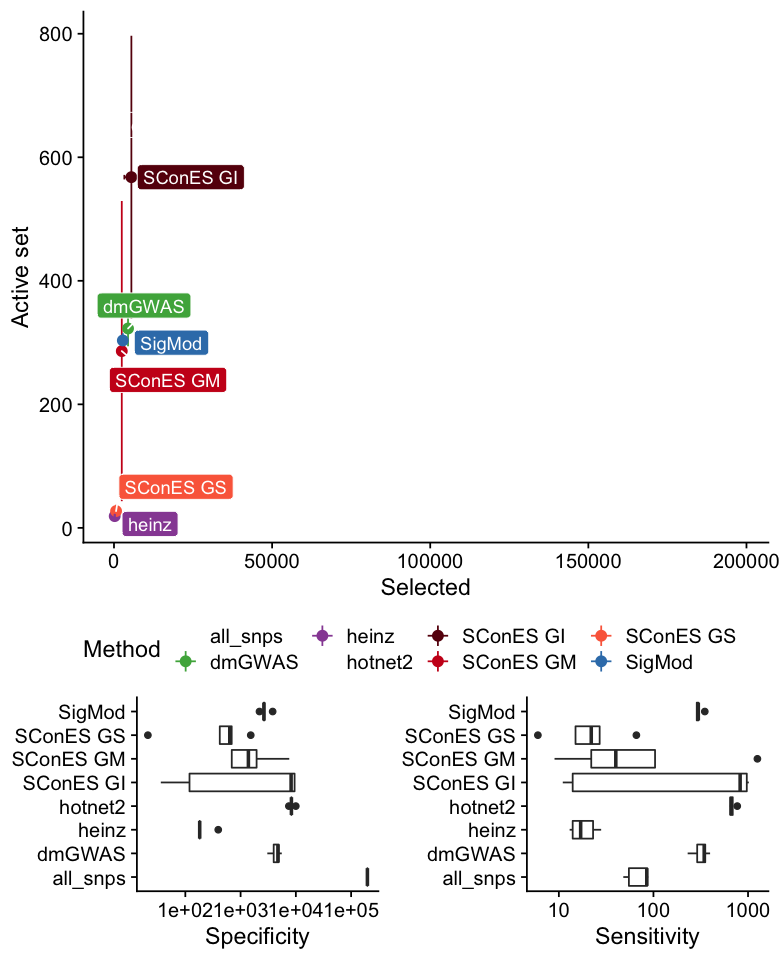

In [13]:
options(repr.plot.width=6.5, repr.plot.height=8)
selected <- ggplot(pred_lc, aes(x = method, y = n_selected)) +
    geom_boxplot() +
    scale_y_log10() +
    coord_flip() +
    labs(y = 'Specificity') +
    theme(axis.title.y = element_blank())

active <- ggplot(pred_lc, aes(x = method, y = n_active_set)) +
    geom_boxplot() +
    scale_y_log10() +
    coord_flip() +
    labs(y = 'Sensitivity') +
    theme(axis.title.y = element_blank())

sel_act <- pred_lc %>%
    group_by(method) %>%
    summarize(se_selected = sd(n_selected) / sqrt(n()),
              se_active = sd(n_active_set) / sqrt(n()),
              n_selected = mean(n_selected),
              n_active_set = mean(n_active_set)) %>%
    ggplot(aes(x = n_selected, y = n_active_set, 
               label = method, fill = method, color = method)) +
        geom_pointrange(aes(ymin = n_active_set - se_active, 
                            ymax = n_active_set + se_active)) +
        geom_errorbarh(aes(xmax = n_selected + se_selected, 
                           xmin = n_selected - se_selected)) +
        geom_label_repel(color = 'white') +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Selected', y = 'Active set', color = 'Method') +
        theme(legend.position = 'bottom') + 
        guides(fill = "none")

plot_grid(sel_act, plot_grid(selected, active), nrow = 2, rel_heights = c(2.5,1))

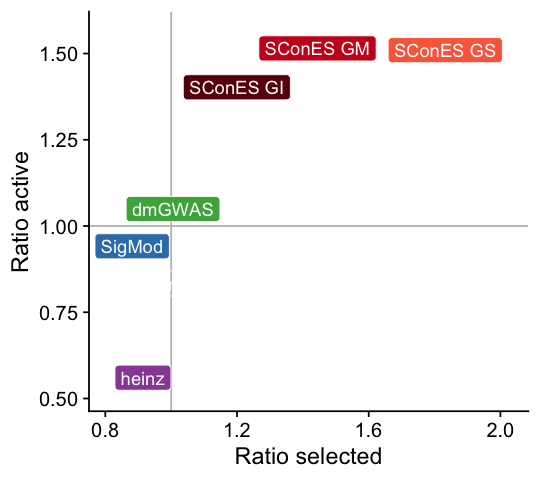

In [14]:
options(repr.plot.width=4.5, repr.plot.height=4)
inner_join(pred_lc %>%
           group_by(method) %>%
           summarize(n_selected = mean(n_selected),
                     n_active = mean(n_active_set)),
           pred_ht %>%
           group_by(method) %>%
           summarize(n_selected = mean(n_selected),
                     n_active = mean(n_active_set)),
           by = 'method', suffix = c('_ht','_lc')) %>%
    group_by(method) %>%
    summarize(delta_selected = n_selected_lc/n_selected_ht,
              delta_active = n_active_lc/n_active_ht) %>%
    ggplot(aes(x = delta_selected, y = delta_active, 
               label = method, fill = method)) +
        geom_hline(yintercept = 1, color = 'gray') +
        geom_vline(xintercept = 1, color = 'gray') +
        geom_label_repel(color = 'white') +
        scale_fill_manual(values = method_palette) +
        labs(x = 'Ratio selected', y = 'Ratio active') +
        theme(legend.position = 'none')